In [1]:
from tracemalloc import stop
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import sys
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
sys.path.insert(1, "D:/AppProgPython/appprog/Lab4")
from df_functions import make_dataframe
from preprocess import preprocess_text

In [22]:
def change_label(data:pd.DataFrame, rate: int) -> pd.DataFrame:
    data.dropna(inplace=True)
    labels = lambda x: 1 if x == rate else 0
    data['label'] = data['Рейтинг'].apply(labels)
    return data

In [23]:
def load_data(file_path: str) -> pd.DataFrame:
    data = make_dataframe(file_path)
    data = preprocess_text(data)
    return data

In [24]:
def vectorizer(df: pd.DataFrame):
    cv = CountVectorizer(max_features=1000, stop_words=stopwords.words('russian'))
    sparse_matrix = cv.fit_transform(df["Текст отзыва"]).toarray()
    return sparse_matrix

In [25]:
def split_data(all_data, df:pd.DataFrame):
    text = np.array(df["label"])
    x_train, x_test, y_train, y_test = train_test_split(all_data, text)
    return x_train, x_test, y_train, y_test


In [26]:
df = load_data('D:/AppProgPython/appprog/csv/final1.csv')
changed = change_label(df, 1)
vec = vectorizer(changed)
print(split_data(vec, changed))

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int64), array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64), array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int64))


In [33]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(1000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
x_train, x_test, y_train, y_test = split_data(vec, changed)
model = LogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters() , lr=0.01)
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

In [28]:
epochs = 20
model.train()
loss_values = []
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss_values.append(loss.item())
    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)
    print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
    loss.backward()
    optimizer.step()

Epoch: 1, Loss: 0.7212693691253662, Accuracy: 21.62162208557129%
Epoch: 2, Loss: 0.62000972032547, Accuracy: 91.89189147949219%
Epoch: 3, Loss: 0.4523933529853821, Accuracy: 100.0%
Epoch: 4, Loss: 0.25985485315322876, Accuracy: 100.0%
Epoch: 5, Loss: 0.11852061748504639, Accuracy: 100.0%
Epoch: 6, Loss: 0.0481734536588192, Accuracy: 100.0%
Epoch: 7, Loss: 0.019367558881640434, Accuracy: 100.0%
Epoch: 8, Loss: 0.0084755914285779, Accuracy: 100.0%
Epoch: 9, Loss: 0.0036615943536162376, Accuracy: 100.0%
Epoch: 10, Loss: 0.0015709168510511518, Accuracy: 100.0%
Epoch: 11, Loss: 0.0006491430103778839, Accuracy: 100.0%
Epoch: 12, Loss: 0.00025858174194581807, Accuracy: 100.0%
Epoch: 13, Loss: 0.00010091059084516019, Accuracy: 100.0%
Epoch: 14, Loss: 3.9369060687022284e-05, Accuracy: 100.0%
Epoch: 15, Loss: 1.5579786122543737e-05, Accuracy: 100.0%
Epoch: 16, Loss: 6.413996743503958e-06, Accuracy: 100.0%
Epoch: 17, Loss: 2.7932203465752536e-06, Accuracy: 100.0%
Epoch: 18, Loss: 1.26294469282584

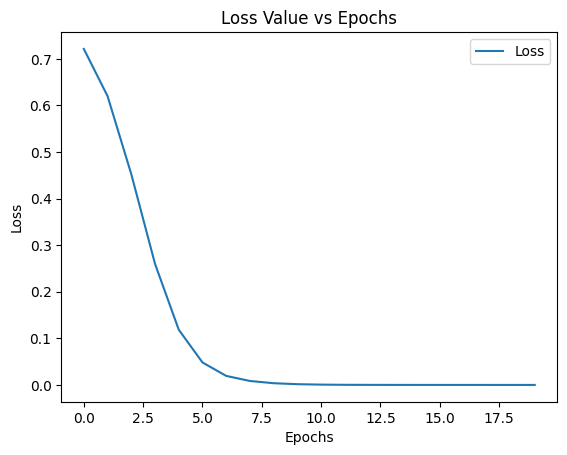

In [29]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

In [34]:
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    print ("Accuracy : {}%".format(100*pred/len(x_test)))

Accuracy : 92.30769348144531%
